In [228]:
#Imports the dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

C:\Users\Sivert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Sivert\.cache\kagglehub\datasets\shashanknecrothapa\ames-housing-dataset\versions\1


In [229]:
# Reads the csv file into a pandas dataframe
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
data = pd.read_csv(path + "/AmesHousing.csv")

# Bin the SalePrice for stratification (e.g., 10 bins)
data['SalePrice_bin'] = pd.qcut(data['SalePrice'], q=10, duplicates='drop', labels=False)

# Stratified split: 80% train, 20% test
trainData, testData = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data['SalePrice_bin']
)

def proportions(s: pd.Series):
    return s.value_counts(normalize=True).sort_index()

prop_table = pd.DataFrame({
    'overall': proportions(data['SalePrice_bin']),
    'train':   proportions(trainData['SalePrice_bin']),
    'test':    proportions(testData['SalePrice_bin'])
})
display(prop_table)

# Drop the bin column after splitting
trainData = trainData.drop(columns=['SalePrice_bin'])
testData = testData.drop(columns=['SalePrice_bin'])


print("Train shape:", trainData.shape)
print("Test shape:", testData.shape)

,overall,train,test
SalePrice_bin,,,
0,0.100000,0.099829,0.100683
1,0.103413,0.103669,0.102389
2,0.100000,0.099829,0.100683
3,0.097952,0.098123,0.097270
4,0.099317,0.099403,0.098976
5,0.099317,0.099403,0.098976
6,0.100341,0.100256,0.100683
7,0.102048,0.101962,0.102389
8,0.097611,0.097696,0.097270


Train shape: (2344, 82)
Test shape: (586, 82)


In [230]:
# Prepearing data for training and testing
dfTest = pd.DataFrame(testData)
dfTrain = pd.DataFrame(trainData)

def clean_data(df, colsToRemove, threshold=0.9):
    dfClean = df.copy()
    dfClean.drop(columns=colsToRemove, inplace=True)

    na_frac = dfClean.isna().mean()
    cols_to_drop = na_frac[na_frac > threshold].index.tolist()
    dfClean.drop(columns=cols_to_drop)
    dfCleaned = dfClean.copy()
    for col in dfClean.columns:
        if dfClean[col].dtype == 'object':
            dfCleaned[col] = dfClean[col].fillna('None')
        else:
            dfCleaned[col] = dfClean[col].fillna(dfCleaned[col].median())
    return dfCleaned

colsToRemove = ['Order', 'PID']

dfTrain = clean_data(dfTrain, colsToRemove=colsToRemove)
dfTest = clean_data(dfTest, colsToRemove=colsToRemove)


In [231]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
def feature_engineering(df):
    df['Total SF'] = (df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area'])
    df['Total Bathrooms'] = (df['Full Bath'] + 0.5 * df['Half Bath'] + df['Bsmt Full Bath'] + 0.5 * df['Bsmt Half Bath'])
    df['Total Porch SF'] = (df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
    df['Has Pool'] = np.where(df['Pool Area'] > 0, 1, 0)
    df['Has Garage'] = np.where(df['Garage Area'] > 0, 1, 0)
    df['Has Fireplace'] = np.where(df['Fireplaces'] > 0, 1, 0)

    colsToRemove = ['1st Flr SF', '2nd Flr SF', 'Pool Area', 'Fireplaces',
                    'Total Bsmt SF', 'Garage Area', 'Full Bath', 'Half Bath', 'Bsmt Full Bath',
                    'Bsmt Half Bath', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch']
    df.drop(columns=colsToRemove, inplace=True)
    display(df.head())
    return df

dfTrain = feature_engineering(dfTrain)
dfTest = feature_engineering(dfTest)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Heating,Heating QC,Central Air,Electrical,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
2248,85,RL,68.0,7540,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,6,6,1978,1978,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,773.0,Unf,0.0,115.0,GasA,Ex,Y,SBrkr,0,912,2,1,TA,5,Typ,TA,Attchd,1978.0,RFn,2.0,TA,TA,Y,0,None,MnPrv,None,0,6,2007,WD,Normal,156000,2270.0,2.0,192,0,1,1
2579,20,RL,72.0,10152,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1956,1994,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,914.0,Unf,0.0,210.0,GasA,Ex,Y,SBrkr,0,1124,3,1,TA,6,Typ,TA,Attchd,1956.0,Fin,1.0,TA,TA,Y,0,None,None,None,0,5,2006,WD,Normal,153000,2601.0,2.0,533,0,1,1
2691,70,RM,60.0,7518,Pave,None,Reg,Lvl,AllPub,FR3,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,8,1910,2004,Gable,CompShg,AsbShng,Plywood,None,0.0,Fa,Gd,BrkTil,Fa,Fa,No,Unf,0.0,Unf,0.0,396.0,GasA,Gd,Y,SBrkr,0,1330,3,1,TA,7,Typ,None,Detchd,2001.0,Unf,1.0,TA,TA,N,0,None,MnPrv,None,0,7,2006,WD,Normal,116500,2116.0,1.0,117,0,1,0
1264,20,RL,68.0,12929,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1960,1993,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,276.0,TA,TA,CBlock,TA,TA,Gd,GLQ,697.0,Unf,0.0,384.0,GasA,TA,Y,SBrkr,0,1081,3,1,TA,5,Typ,None,CarPort,1960.0,Unf,1.0,TA,TA,Y,36,None,None,None,0,6,2008,WD,Normal,148000,2563.0,2.0,82,0,1,0
1437,60,RL,68.0,9179,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,BrkFace,158.0,Gd,TA,PConc,Gd,TA,No,GLQ,633.0,Unf,0.0,240.0,GasA,Ex,Y,SBrkr,0,1790,3,1,Gd,7,Typ,None,Attchd,1999.0,RFn,2.0,TA,TA,Y,0,None,None,None,0,6,2008,WD,Abnorml,193000,3251.0,3.5,88,0,1,0


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Heating,Heating QC,Central Air,Electrical,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
795,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,GasA,TA,Y,SBrkr,0,1049,2,1,Gd,5,Typ,None,Attchd,1984.0,Fin,1.0,TA,TA,Y,0,None,None,None,0,2,2009,WD,Normal,139500,2364.0,3.0,105,0,1,0
547,160,RL,75.0,10762,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,626.0,GasA,TA,Y,SBrkr,0,1217,3,1,TA,6,Typ,TA,Attchd,1980.0,RFn,1.0,TA,TA,Y,0,None,None,None,0,4,2009,WD,Normal,120000,2131.0,1.5,28,0,1,1
2470,20,RL,74.0,7733,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,Mn,GLQ,24.0,Unf,0.0,1118.0,GasA,Ex,Y,SBrkr,0,1142,3,1,Gd,5,Typ,None,None,1980.0,None,0.0,None,None,Y,4,None,None,None,0,1,2006,WD,Normal,139500,2284.0,1.5,50,0,0,0
959,20,RL,113.0,13438,Pave,None,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2008,2008,Gable,CompShg,CemntBd,CmentBd,Stone,246.0,Ex,TA,CBlock,Ex,TA,Gd,GLQ,1758.0,Unf,0.0,432.0,GasA,Ex,Y,SBrkr,0,2036,3,1,Ex,9,Typ,Ex,Attchd,2008.0,Fin,3.0,TA,TA,Y,90,None,None,None,0,7,2009,WD,Normal,410000,5006.0,3.0,154,0,1,1
1979,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,1885,1995,Mansard,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,641.0,GasA,Gd,Y,SBrkr,0,1047,2,1,TA,6,Typ,None,Detchd,1954.0,Unf,1.0,Fa,Fa,N,0,None,None,Shed,450,8,2007,WD,Normal,100000,1961.0,1.0,0,0,1,0


In [232]:
# Seperated the first feature of the data set from the later features
# x contains all features found to be relevant for predicting sale price
# y contains only sale price
x_train = dfTrain.drop(columns=['SalePrice'])
y_train = dfTrain['SalePrice']
x_test = dfTest.drop(columns=['SalePrice'])
y_test = dfTest['SalePrice']


print ("x_train shape:", x_train.shape)
print(x_train)

x_train shape: (2344, 71)
      MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
2248           85        RL          68.0      7540   Pave  None       IR1   
2579           20        RL          72.0     10152   Pave  None       Reg   
2691           70        RM          60.0      7518   Pave  None       Reg   
1264           20        RL          68.0     12929   Pave  None       IR1   
1437           60        RL          68.0      9179   Pave  None       IR1   
1171          120        FV          50.0      5119   Pave  None       IR1   
1003           60        RL         100.0     10839   Pave  None       IR1   
1039          160        RM          21.0      1680   Pave  None       Reg   
2446           60        RL          68.0      9233   Pave  None       IR1   
357            60        RL          68.0      9765   Pave  None       IR2   
1966           20        RL          80.0      8000   Pave  None       Reg   
2309           20        RL          9

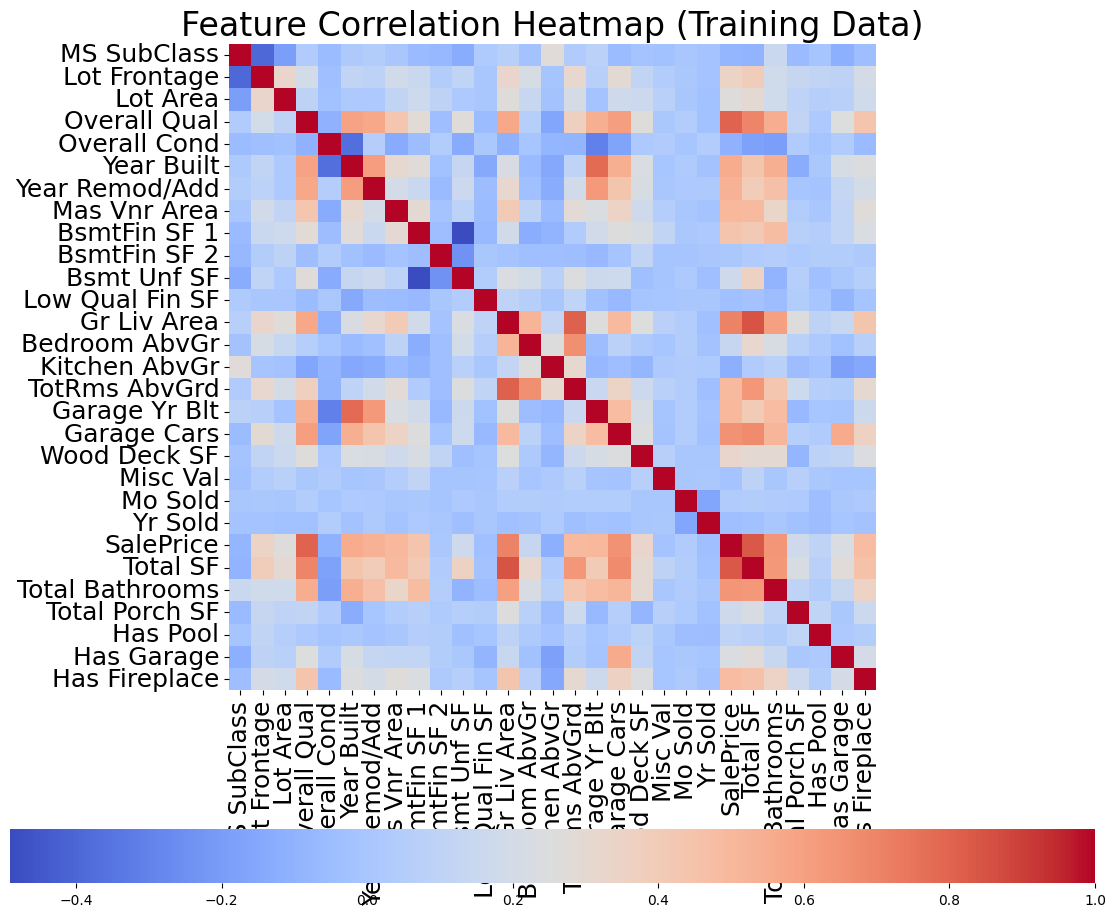

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = dfTrain.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"orientation": "horizontal"}
)
plt.title("Feature Correlation Heatmap (Training Data)", fontsize=24)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()


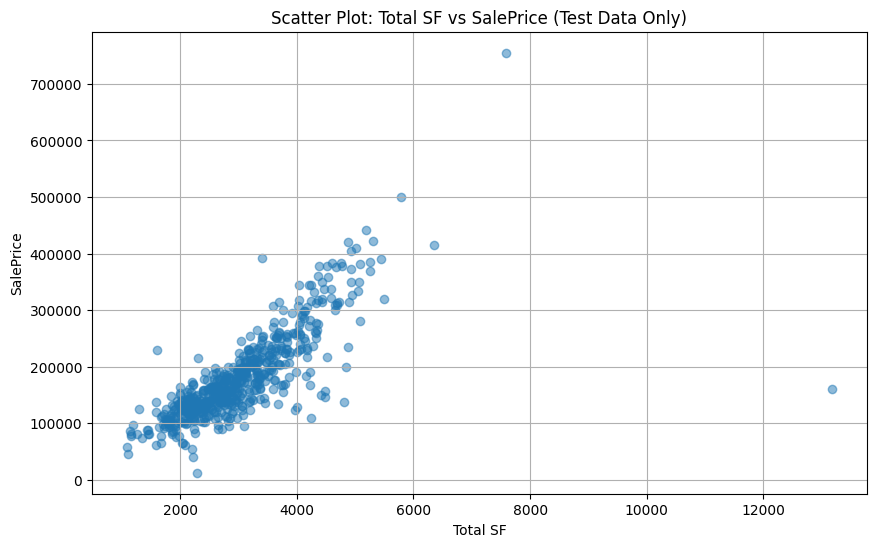

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(dfTest['Total SF'], dfTest['SalePrice'], alpha=0.5)
plt.xlabel('Total SF')
plt.ylabel('SalePrice')
plt.title('Scatter Plot: Total SF vs SalePrice (Test Data Only)')
plt.grid(True)
plt.show()


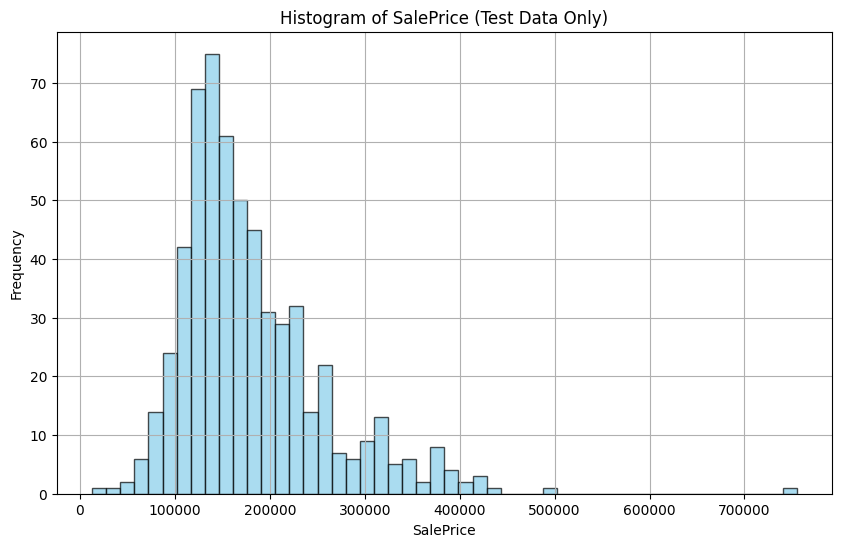

In [235]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dfTest['SalePrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice (Test Data Only)')
plt.grid(True)
plt.show()




In [236]:
# Create histograms for all numeric columns that appear in the heat map
import matplotlib.pyplot as plt

# Only include numeric columns that appear in the heat map
numeric_df = dfTrain.select_dtypes(include='number')
numeric_cols = numeric_df.columns

for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    plt.hist(dfTrain[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col} (Train Data Only)')
    plt.grid(True)
    plt.show()

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


,steps,"[('preprocessor', ...), ('poly_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


,steps,"[('preprocessor', ...), ('poly_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

numeric_cols = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns.tolist()


numeric_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transform, numeric_cols),
    ('cat', categorical_transform, categorical_cols)
])


ensambleModel = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    ))
])

linearModel = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

polyModel = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

display(ensambleModel)
display(linearModel)
display(polyModel)

# Train the models
ensambleModel.fit(x_train, y_train)
linearModel.fit(x_train, y_train)
polyModel.fit(x_train, y_train)



In [237]:
y_pred_ensamble = ensambleModel.predict(x_test)
y_pred_linear = linearModel.predict(x_test)
y_pred_poly = polyModel.predict(x_test)

mse_ensamble = mean_squared_error(y_test, y_pred_ensamble)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_poly = mean_squared_error(y_test, y_pred_poly)

rmse_ensamble = np.sqrt(mse_ensamble)
rmse_linear = np.sqrt(mse_linear)
rmse_poly = np.sqrt(mse_poly)

r2_ensamble = r2_score(y_test, y_pred_ensamble)
r2_linear = r2_score(y_test, y_pred_linear)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Ensamble Model - RMSE: {rmse_ensamble:.2f}, R²: {r2_ensamble:.4f}")
print(f"Linear Model - RMSE: {rmse_linear:.2f}, R²: {r2_linear:.4f}")
print(f"Polynomial Model - RMSE: {rmse_poly:.2f}, R²: {r2_poly:.4f}")

Ensamble Model - RMSE: 28354.34, R²: 0.8655
Linear Model - RMSE: 37747.54, R²: 0.7616
Polynomial Model - RMSE: 30928.82, R²: 0.8399
